# Quantum Amplitude Estimation

Given an operator $\mathcal{A}$ that acts as

$$
    \mathcal{A}|0\rangle = \sqrt{1 - a}|\Psi_0\rangle + \sqrt{a}|\Psi_1\rangle
$$

Quantum Amplitude Estimation (QAE) is the task of finding an estimate for the amplitude $a$ of the state $|\Psi_1\rangle$:

$$
    a = |\langle\Psi_1 | \Psi_1\rangle|^2.
$$

This task has first been investigated by Brassard et al. [1] in 2000 and their algorithm uses a combination of the Grover operator 

$$
    \mathcal{Q} = \mathcal{A}\mathcal{S}_0\mathcal{A}^\dagger\mathcal{S}_{\Psi_1}
$$

where $\mathcal{S}_0$ and $\mathcal{S}_{\Psi_1}$ are reflections about the $|0\rangle$ and $|\Psi_1\rangle$ states, respectively, and phase estimation. However this algorithm, called [AmplitudeEstimation](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.AmplitudeEstimation.html) in [Qiskit Algorithms](https://qiskit-community.github.io/qiskit-algorithms/), requires large circuits and is computationally expensive. Therefore, other variants of QAE have been proposed, which we will showcase in this tutorial for a simple example.

In our example, $\mathcal{A}$ describes a Bernoulli random variable with (assumed to be unknown) success probability $p$:

$$
    \mathcal{A}|0\rangle = \sqrt{1 - p}|0\rangle + \sqrt{p}|1\rangle.
$$

On a quantum computer, we can model this operator with a rotation around the $Y$-axis of a single qubit

$$
\mathcal{A} = R_Y(\theta_p), \theta_p = 2\sin^{-1}(\sqrt{p}).
$$

The Grover operator for this case is particularly simple

$$
\mathcal{Q} = R_Y(2\theta_p),
$$

whose powers are very easy to calculate: $\mathcal{Q}^k = R_Y(2k\theta_p)$.

We'll fix the probability we want to estimate to $p = 0.2$.

In [1]:
p = 0.2

Now we can define circuits for $\mathcal{A}$ and $\mathcal{Q}$. 

In [2]:
import numpy as np
from qiskit.circuit import QuantumCircuit


class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k

In [3]:
A = BernoulliA(p)
Q = BernoulliQ(p)

### Amplitude Estimation workflow

Qiskit Algorithms implements several QAE algorithms that all derive from the [AmplitudeEstimator](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.AmplitudeEstimator.html) interface. In the initializer we specify algorithm specific settings and the `estimate` method, which does all the work, takes an [EstimationProblem](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.EstimationProblem.html) as input and returns an [AmplitudeEstimationResult](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.AmplitudeEstimatorResult.html) object. Since all QAE variants follow the same interface, we can use them all to solve the same problem instance. 

Next, we'll run all different QAE algorithms. To do so, we first define the estimation problem which will contain the $\mathcal{A}$ and $\mathcal{Q}$ operators as well as how to identify the $|\Psi_1\rangle$ state, which in this simple example is just $|1\rangle$.

In [4]:
from qiskit_algorithms import EstimationProblem

problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

To execute circuits we'll use `Sampler`.

In [5]:
from qiskit.primitives import Sampler

sampler = Sampler()

### Canonical AE

Now let's solve this with the original QAE implementation by Brassard et al. [1].

In [6]:
from qiskit_algorithms import AmplitudeEstimation

ae = AmplitudeEstimation(
    num_eval_qubits=3,  # the number of evaluation qubits specifies circuit width and accuracy
    sampler=sampler,
)

With the algorithm defined, we can call the `estimate` method and provide it with the problem to solve.

In [7]:
ae_result = ae.estimate(problem)

The estimate is available in the `estimation` key:

In [8]:
print(ae_result.estimation)

0.1464466


We see that this is not a very good estimate for our target of $p=0.2$! That's due to the fact the canonical AE is restricted to a discrete grid, specified by the number of evaluation qubits:

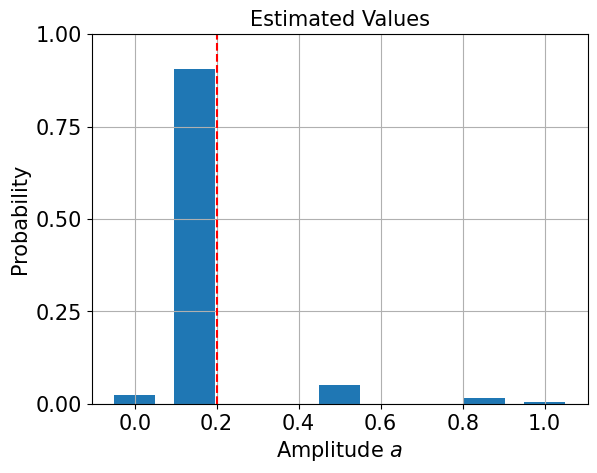

In [9]:
import matplotlib.pyplot as plt

# plot estimated values
gridpoints = list(ae_result.samples.keys())
probabilities = list(ae_result.samples.values())

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(p, color="r", ls="--")
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title("Estimated Values", size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()

To improve the estimate we can interpolate the measurement probabilities and compute the maximum likelihood estimator that produces this probability distribution:

In [10]:
print("Interpolated MLE estimator:", ae_result.mle)

Interpolated MLE estimator: 0.19999999403255486


We can have a look at the circuit that AE executes:

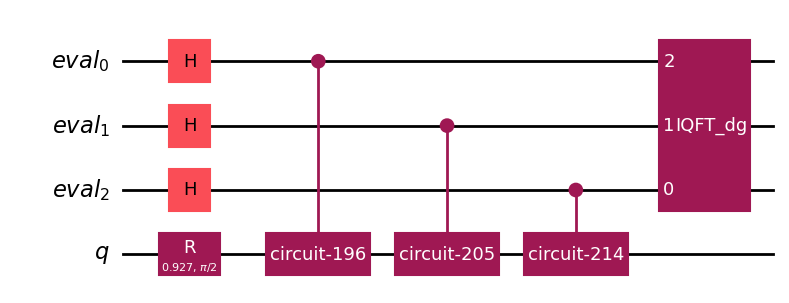

In [11]:
ae_circuit = ae.construct_circuit(problem)
ae_circuit.decompose().draw(
    "mpl", style="iqx"
)  # decompose 1 level: exposes the Phase estimation circuit!

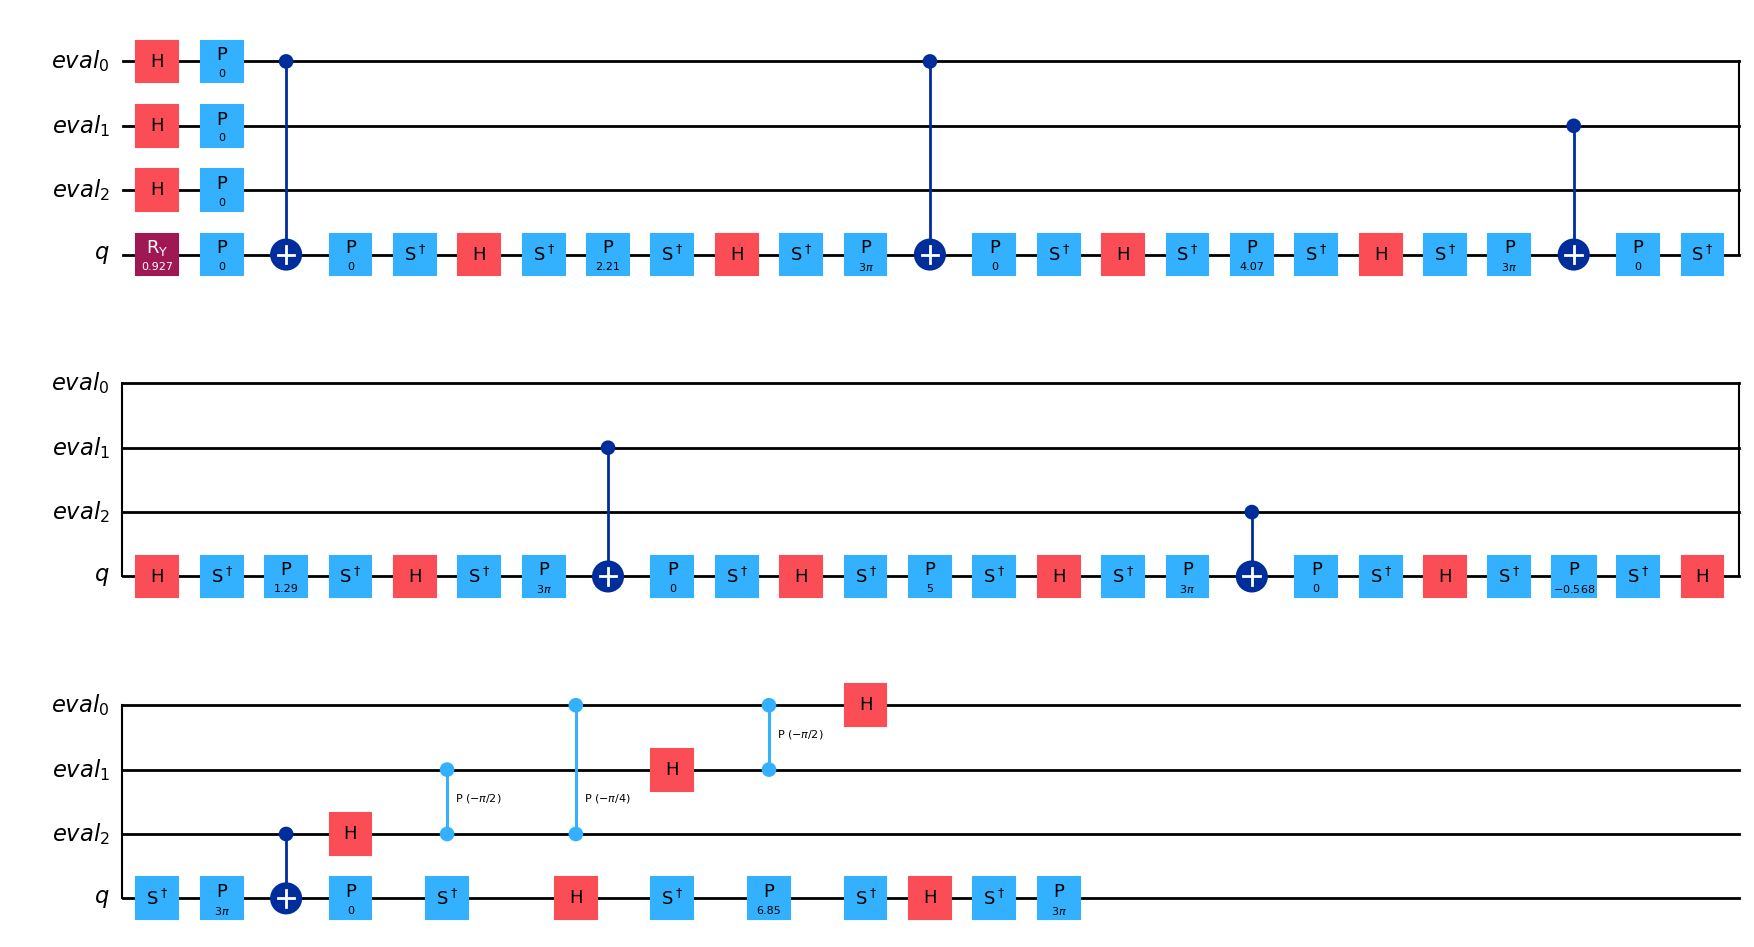

In [12]:
from qiskit import transpile


basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2).draw("mpl", style="iqx")

### Iterative Amplitude Estimation

See [2].

In [13]:
from qiskit_algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    sampler=sampler,
)
iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation)

Estimate: 0.2


The circuits here only consist of Grover powers and are much cheaper!

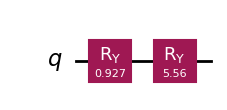

In [14]:
iae_circuit = iae.construct_circuit(problem, k=3)
iae_circuit.draw("mpl", style="iqx")

### Maximum Likelihood Amplitude Estimation

See [3].

In [15]:
from qiskit_algorithms import MaximumLikelihoodAmplitudeEstimation

mlae = MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=3,  # log2 of the maximal Grover power
    sampler=sampler,
)
mlae_result = mlae.estimate(problem)

print("Estimate:", mlae_result.estimation)

Estimate: 0.20002237175368104


### Faster Amplitude Estimation

See [4].

In [16]:
from qiskit_algorithms import FasterAmplitudeEstimation

fae = FasterAmplitudeEstimation(
    delta=0.01,  # target accuracy
    maxiter=3,  # determines the maximal power of the Grover operator
    sampler=sampler,
)
fae_result = fae.estimate(problem)

print("Estimate:", fae_result.estimation)

Estimate: 0.19779758191136476


/opt/hostedtoolcache/Python/3.8.18/x64/lib/python3.8/site-packages/qiskit_algorithms/amplitude_estimators/estimation_problem.py:209: UserWarning: Rescaling discards the Grover operator.
  warnings.warn("Rescaling discards the Grover operator.")


### References

[1] Quantum Amplitude Amplification and Estimation. Brassard et al (2000). https://arxiv.org/abs/quant-ph/0005055

[2] Iterative Quantum Amplitude Estimation. Grinko, D., Gacon, J., Zoufal, C., & Woerner, S. (2019). https://arxiv.org/abs/1912.05559

[3] Amplitude Estimation without Phase Estimation. Suzuki, Y., Uno, S., Raymond, R., Tanaka, T., Onodera, T., & Yamamoto, N. (2019). https://arxiv.org/abs/1904.10246

[4] Faster Amplitude Estimation. K. Nakaji (2020). https://arxiv.org/pdf/2003.02417.pdf

In [17]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

/tmp/ipykernel_2352/1492642725.py:1: DeprecationWarning: qiskit.tools.jupyter is deprecated and will be removed in Qiskit 1.0.0
  import qiskit.tools.jupyter
